In [1]:
import os

import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

import CompositionalNets.Code.config as comp_net_config
from CompositionalNets.Initialization_Code.vMF_clustering import learn_vmf_clusters, save_cluster_images
from CompositionalNets.Initialization_Code.Learn_mix_model_vMF_view import learn_mix_model_vMF

from src.config import directories
from src.models import UNet
from src.dataset import ClassificationDataset, apply_ct_abdomen_filter, NormalizeInstance, Resize

%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

In [3]:
hdf5_path = os.path.join(directories['chaos'], 'train.hdf5')
hf = h5py.File(hdf5_path, 'r')
images = hf['images']
masks = hf['masks']
images = images[0:1999]
masks = masks[0:1999]

In [9]:
input_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(3),
    transforms.Resize((512, 512)),
#     transforms.CenterCrop((448, 448)),
    transforms.ToTensor(),
])
to_grayscale = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(3),
    transforms.ToTensor(),
])
to_grayscale_numpy = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(3),
    transforms.Lambda(lambda x: np.array(x))
])

In [2]:
import re
import gzip
import nibabel as nib
vol_dir = os.path.join('/home/mattlk/workplace/registrations/affine', 'out')
regex = re.compile('.*\.nii\.gz')
largest_slices = []

for name in sorted(os.listdir(vol_dir)):
    
    if regex.match(name):
        
        fp = os.path.join(vol_dir, name)
        with gzip.open(fp, 'rb') as f:
            
            vol = nib.load(f.filename)
            vol_array = np.array(vol.dataobj, dtype=np.int16)
            
            num_slices = vol_array.shape[2]
            amount = np.zeros(num_slices)
            
            for i in range(num_slices):
                
                s = vol_array[...,i]
                background = s.min()
                amount[i] = np.sum(s==background)
            
            idx = np.argmin(amount)
            slices = [vol_array[...,i] for i in range(idx, idx+1)]
            for largest_slice in slices:
            
#             largest_slice = vol_array[...,np.argmin(amount)]
                largest_slice = apply_ct_abdomen_filter(largest_slice)
                largest_slice = np.rot90(largest_slice, k=1)
                largest_slice = np.stack((largest_slice, largest_slice, largest_slice), axis=2)

                # Normalize between 0 and 1
                largest_slice = (largest_slice - largest_slice.min()) / (largest_slice.max() - largest_slice.min())
                largest_slice = largest_slice.astype(np.float32)
                largest_slices.append(largest_slice)
            
largest_slices = np.asarray(largest_slices)
div = int(len(largest_slices)*0.8)
train_slices = largest_slices[:div]

dataset = ClassificationDataset(train_slices, [0] * len(train_slices), input_transform=transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=1)

/home/mattlk/.virtualenvs/CompNet/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: use the name attribute
  from ipykernel import kernelapp as app


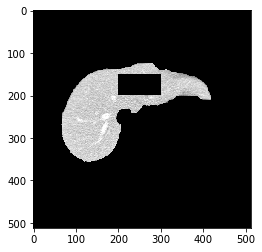

In [3]:
synthetic_images = []
test_slices = largest_slices[div:].copy()

im = test_slices[0].copy()
# im = im[110:390, 50:380]
# im[150:200, 25:125] = im.min()
im[200:300, 100:200] = im.min()
synthetic_images.append(im)

im = test_slices[1].copy()
# im = im[115:370, 50:420]
# im[50:100, 150:250] = im.min()
im[200:300, 100:200] = im.min()
synthetic_images.append(im)


im = test_slices[2].copy()
# im = im[115:385, 50:420]
# im[120:190, 40:135] = im.min()
im[150:200, 200:300] = im.min()
synthetic_images.append(im)

plt.imshow(im)

In [ ]:
data_dir = directories['chaos']
unet_filename = 'unet_liver_2020-08-13_15:52:08.pth'
is_cuda_available = torch.cuda.is_available()
device = device = torch.device("cuda:0" if is_cuda_available else "cpu")

path_to_unet = os.path.join(directories['checkpoints'], unet_filename)
unet = UNet(pretrained=True)
unet.load_state_dict(torch.load(path_to_unet)['model_state_dict'])
if is_cuda_available: unet.to(device)

In [4]:
%%time
segment = True
if segment:
    # input_images = torch.empty(0)
    input_images = []
    for image, mask in zip(images, masks):
        image = input_transform(image)
        image = image.to(device)
        image = image.unsqueeze(0)

        with torch.no_grad():
            out = unet(image)
            scores = F.softmax(out, dim=1)

#             segmentations = torch.round(F.threshold(scores[:, 1, :, :], 0.9, 0))
            # Using the ground truth mask
            segmentations = [torch.Tensor(mask)]
            
            processed_image = segmentations[0].unsqueeze(0).cuda() * image
#             processed_image = segmentations.unsqueeze(1) * image
            processed_image = processed_image.detach().cpu()
#             processed_image = image.detach().cpu()
            
    #         input_images = torch.cat((input_images, processed_image))
            for seg, im in zip(segmentations, processed_image):
                _, contours, _ = cv2.findContours(seg.cpu().numpy().astype(np.uint8),
                                                  cv2.RETR_EXTERNAL, 
                                                  cv2.CHAIN_APPROX_NONE)
                if contours:
                    y, x, h, w = cv2.boundingRect(contours[0])
                    cropped_im = im[:, x:x+w, y:y+h]
                else:
                    cropped_im = im

            h, w = cropped_im.shape[1], cropped_im.shape[2]
            # Otherwise clustering encoder reduces feature map to a dimension of 0
            if h < 50 or w < 50:
                continue
                
            input_images.append(cropped_im)
else:
    input_images = images

dataset = ClassificationDataset(input_images, [0] * len(input_images),
                               to_grayscale)
data_loader = DataLoader(dataset, batch_size=1)
print(f'Number of images: {len(dataset)}')

Number of images: 1907
CPU times: user 1min 20s, sys: 47.3 s, total: 2min 7s
Wall time: 2min 8s


# VMF Clustering

In [7]:
vmf, loc_set =  learn_vmf_clusters(data_loader, img_per_cat=len(dataset), verbose=True,
                                     max_it=300, tol=5e-12,
                                     u_out_name='chaos_pool5_128_u_test_3.pickle',
#                                      u_out_name='chaos_pool5_512_u.pickle',
                                     p_out_name='chaos_pool5_128_p_test_3.pickle')
#                                      p_out_name='chaos_pool5_512_p.pickle')

Early stop at iter 19, llk 29.5208299680266


## Cluster Visualizations

In [116]:
images = dataset.X
# images = np.asarray([(to_grayscale(im).permute(1,2,0).numpy()*255).astype(np.uint8) 
#                      for im in input_images])
# images = np.asarray([(to_grayscale(im).permute(1,2,0).numpy()*255).astype(np.uint8)
#                      for im in input_images.detach().cpu()])
# import matplotlib.pyplot as plt
# plt.imshow(images[0])

In [117]:
save_cluster_images(vmf, loc_set, in_images=images,
                    num_images=16, out_dir_name='test',
                    max_num_clusters=20)

Saving top 16 images for each cluster


# Similarity Matrix

In [8]:
import CompositionalNets.Code.config as comp_net_config
import CompositionalNets.Initialization_Code.config_initialization as comp_net_init_config
from CompositionalNets.Initialization_Code.comptSimMat import compute_similarity_matrix
import pdb

max_images 5000


In [15]:
%%time
# pdb.set_trace()
mat1, mat2 = compute_similarity_matrix(data_loader, 0, 'test_2',
                                       sim_dir_name='similarity_unet_pool5_chaos',
                                       u_out_name='chaos_pool5_128_u_test_3.pickle',
                                       N_sub=16, num_layer_features=1)

Determine best threshold for binarization - 0 ...
Start compute sim matrix ... magicThresh 0.45
iter 1/1 1/1


/home/mattlk/.virtualenvs/CompNet/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

# vMF Mixture Model

In [16]:
learn_mix_model_vMF(data_loader, 0, sim_matrix_name='test_2',
                    num_layers=1, num_clusters_per_layer=1,
                    sim_dir_name='similarity_vgg_pool5_chaos',
                    dict_filename='chaos_pool5_128_u_test.pickle',
                    mixdir_name=f'mix_model_vmf_chaos_EM_all_test/',
                    im_channels=3)

FileNotFoundError: [Errno 2] No such file or directory: '/project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/models/init_unet/dictionary_unet/chaos_pool5_128_u_test.pickle'

# Localize Occluders

In [17]:
from torchvision import models
from PIL import Image

from src.dataset import NormalizeInstance, ClassificationDataset
from src.utils import create_canvas
from src.models import UNet
from src.metrics import dice_loss, dice_score
from src.utils import create_canvas
from src.train import train_one_epoch, validate
from src.config import directories

from CompositionalNets.Code.config import categories, data_path, device_ids, categories_train, mix_model_path, dict_dir, layer, vMF_kappa, model_save_dir, compnet_type, backbone_type, num_mixtures
from CompositionalNets.Code.config import config as cfg
from CompositionalNets.Code.model import Net, resnet_feature_extractor
from CompositionalNets.Code.helpers import getVmfKernels, getCompositionModel, update_clutter_model
from CompositionalNets.Code.eval_occlusion_localization import visualize_response_map
from CompositionalNets.Code.losses import ClusterLoss
from CompositionalNets.Initialization_Code.config_initialization import extractor

In [129]:
%%time
occ_likely = [0.6 for _ in range(len(categories_train))]

dict_dir = os.path.join(directories['CompositionalNets'],
                        'models/init_vgg/dictionary_vgg/chaos_pool5_128_u_test.pickle')
weights = getVmfKernels(dict_dir, device_ids)
mix_model_path = os.path.join(directories['CompositionalNets'], 
                             'models/init_vgg/mix_model_vmf_chaos_EM_all_test/')
mix_models = getCompositionModel(device_ids, mix_model_path, layer, 
                                 [0],
                                 compnet_type=compnet_type,
                                 num_mixtures=num_mixtures)

model = Net(extractor, weights, vMF_kappa, occ_likely, mix_models, 
            bool_mixture_bg=True,
            compnet_type=compnet_type, num_mixtures=num_mixtures, 
            vc_thresholds=cfg.MODEL.VC_THRESHOLD)
if device_ids:
    model.to(device_ids[0])

Early stop at iter 2, llk 29.302689851290054
CPU times: user 427 ms, sys: 28.2 ms, total: 455 ms
Wall time: 496 ms


In [32]:
train_hdf5_fp = os.path.join(directories['lits'], 'train.hdf5')
with h5py.File(train_hdf5_fp, 'r') as hf:
    image_dataset = hf['images'][40:60]
    target_dataset = hf['masks'][40:60]

lits_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(3),
    transforms.Resize((512, 512)),
#     transforms.CenterCrop((448, 448)),
    transforms.ToTensor(),
])

test_dataset = ClassificationDataset(image_dataset, target_dataset, 
                                     input_transform=lits_transform)

# Batch size must be 1! Tight cropping will change each input image's 
# dimension
test_dataloader = DataLoader(test_dataset, batch_size=1, pin_memory=False)

In [ ]:
import pdb
idx = 10
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        image, mask = data
        
        if device_ids:
            image = image.cuda(device_ids[0])
            
        out = unet(image)
        scores = F.softmax(out, dim=1)

        segmentations = torch.round(F.threshold(scores[:, 1, :, :], 0.9, 0))
        processed_images = segmentations.unsqueeze(1) * image
#         processed_images = image
        
        seg_map = segmentations.squeeze().cpu().numpy().astype(np.uint8)
        seg_liver = processed_images.squeeze()
        
        _, contours, _ = cv2.findContours(seg_map, cv2.RETR_EXTERNAL, 
                                          cv2.CHAIN_APPROX_NONE)
        
        if contours:
            y, x, h, w = cv2.boundingRect(contours[0])
#             seg_liver = seg_liver[:, x:x+w, y:y+h]
#             mask = mask[x:x+w, y:y+h, :]

        h, w = seg_liver.shape[1], seg_liver.shape[2]
        
        mask = np.array(Image.fromarray(mask.squeeze().numpy()*255//2, mode='F').convert('RGB'))
        # Clustering encoder reduces feature map to a dimension of 0 if h,w 
        # lower than 31. Set to be something larger so that the feature map is
        # large enough to have meaningful features
        if h < 50 or w < 50:
            continue
            scaling_factor = math.ceil(31 / min(h, w))
            dim = (scaling_factor * h, scaling_factor * w)
            
            # Need to permute when turning to numpy array so that resizing 
            # works and restore dimension back when back to tensor
            seg_liver = cv2.resize(seg_liver.permute(1, 2, 0).cpu().numpy(), dim)
            seg_liver = torch.Tensor(seg_liver).permute(2, 0, 1)
        
        if device_ids:
            seg_liver = seg_liver.to(device_ids[0])
        
        seg_liver = seg_liver.unsqueeze(0)
        output, *_ = model(seg_liver)
        
        #localize occluder
#         if i == 2: pdb.set_trace() # there's an indexing issue if not using a mixture background
#         pdb.set_trace()
        score, occ_maps, part_scores = model.get_occlusion(seg_liver, 0)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=0)
        
        # concatenate original image and occluder map
#         img_orig = np.array(Image.fromarray(image_dataset[i], mode='F').convert('RGB'))
        img_orig = (seg_liver[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        
        faco = img_orig.shape[0] / occ_img.shape[0]
        
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        mask = cv2.resize(mask, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        
        canvas = np.concatenate((img_orig, occ_img_s, mask), axis=1)
        plt.figure(figsize=(10, 10))
        plt.imshow(canvas)
        plt.axis('off')
        fp = f'{directories["CompositionalNets"]}/results/lits/augment/train_without_occluder/crop_{i}.png'
        cv2.imwrite(fp, canvas)
#         print('Occlusion map written to: {}'.format(out_name))
        if i == idx: break

# Test on Synthetic Images

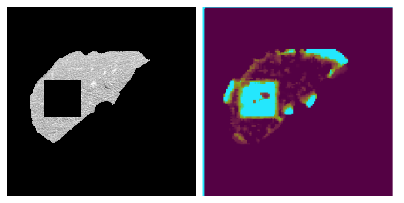

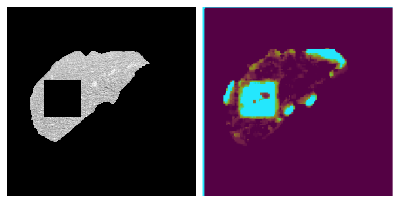

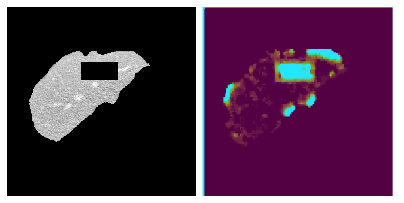

In [130]:
# synthetic_images = [cv2.imread(os.path.join(directories['CompositionalNets'], 'test_images', name)) 
#                     for name in ['liver_black1.JPEG', 'liver_black2.JPEG']]
# hdf5_path_synth = os.path.join(directories['chaos'], 'synthetic.hdf5')
# hf_synth = h5py.File(hdf5_path_synth, 'r')
# synthetic_images = hf_synth['images'][:]

cc = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Grayscale(3),
#     transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
i = 0
with torch.no_grad():
    for image in synthetic_images:
        
        image = cc(image)
        
        if device_ids:
            image = image.cuda(device_ids[0])
            
        image = image.unsqueeze(0)

        #localize occluder
#         if i == 2: pdb.set_trace() # there's an indexing issue if not using a mixture background
        score, occ_maps, part_scores = model.get_occlusion(image, 0)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=0)
        
        # concatenate original image and occluder map
#         img_orig = np.array(Image.fromarray(image_dataset[i], mode='F').convert('RGB'))
        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
#         mask = np.array(Image.fromarray(mask.squeeze().numpy()*255//2, mode='F').convert('RGB'))
        faco = img_orig.shape[0] / occ_img.shape[0]
        
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
#         mask = cv2.resize(mask, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(7, 7))
        plt.imshow(canvas)
        plt.axis('off')
        fp = f'{directories["CompositionalNets"]}/results/lits/train_without_occluder/test_{i}.png'
        cv2.imwrite(fp, canvas)